### Further Hypothesis Testing

In [1]:
# Select this cell and type Ctrl-Enter to execute the code below.

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

data = pd.read_csv("stars.csv")
type_key = ['Brown Dwarf', 'Red Dwarf', 'White Dwarf', 'Main Sequence', 'Supergiant','Hypergiant']


## 8 - Goodness of fit

Your colleague Althea is not a fan of Prof. Xu's temperature scheme. She has her own ideas about how the star classification should be revised.

According to Althea's new theory of stellar evolution, there are two subtypes of hypergiant star, with very different temperature distributions. 

She says that our galaxy has approximately equal numbers of each subtype. 

If this theory is true, hypergiant temperatures should be distributed according to:

$$
P(3000K \leq \text{T} \lt 4000K) = 0.5 \\
P(4000K \leq \text{T} \lt 40000K) = 0.5
$$

with uniform temperature distributions within each of the two subtypes.

Althea asks you to check whether her theory agrees with your data set.

### Question: do hypergiants in the observed data set fit Althea's theory?

The pdf associated with the theory is piecewise uniform. We can construct this as a bespoke continuous probability distribution with `scipy.stats`:

In [2]:
def althea_F(x):
    if(x<3000):
        return 0
    elif(x<4000):
        return 0.5*(x-3000)/(4000-3000)
    elif(x<40000):
        return 0.5 + 0.5*(x-4000)/(40000-4000)
    else:
        return 1

class althea(stats.rv_continuous):
    "Althea's distribution"
    def _cdf(self, x):
        return np.vectorize(althea_F)(x)

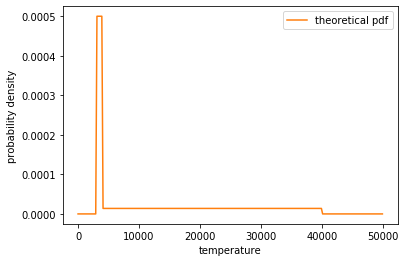

In [3]:
al = althea()
x = np.arange(0,50000,100)

y = []
for z in x:
    y.append(al.pdf(z))

xlab = 'temperature'
ylab = 'probability density'    

ax = plt.axes()
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
plt.plot(x, y, color='tab:orange', label='theoretical pdf')
ax.legend(loc='upper right')
plt.show()    


At first glance, the histogram for the hypergiants (type 5) does appear to have a similar shape to this pdf:

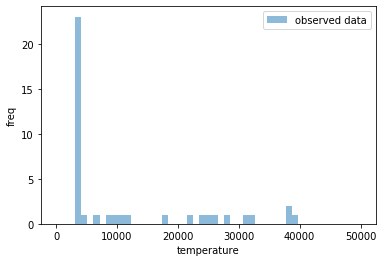

In [4]:
observed = data[data.type == 5].temperature
n = len(observed)

xlab = 'temperature'
ylab = 'freq'

bins = np.linspace(0,50000)
ax = plt.axes()
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
obs_hist = plt.hist(observed, bins, alpha=0.5, label='observed data')
ax.legend(loc='upper right')
plt.show()

To see more clealy, we can overlay a random sample of the same size ($n$=40), drawn from the theoretical distribution:

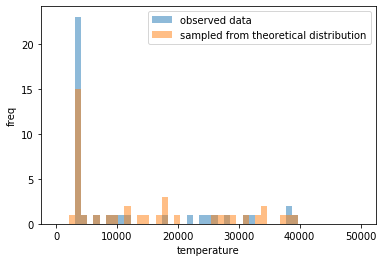

In [7]:
expected = al.rvs(size=n)

xlab = 'temperature'
ylab = 'freq'

bins = np.linspace(0,50000)
ax = plt.axes()
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
obs_hist = plt.hist(observed, bins, alpha=0.5, label='observed data')
exp_hist = plt.hist(expected, bins, alpha=0.5, label='sampled from theoretical distribution')
ax.legend(loc='upper right')
plt.show()

How can we test more formally whether the observed data appear to be drawn from the theoretical distribution?

Here we have a theoretical distribution *which is not directly related to any of the standard statistical distributions*, so parametric methods such as the Shapiro-Wilk test are not applicable.

However, we can still perform a *non-parametric* goodness-of-fit test, by comparing the theoretical cdf with the empirical one:

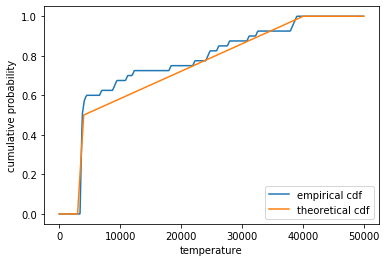

In [8]:
hist = np.histogram(observed, bins=100)
empirical_dist = stats.rv_histogram(hist)

x = np.arange(0,50000,100)

y_theoretical = []
y_empirical = []

for z in x:
    y_theoretical.append(al.cdf(z))
    y_empirical.append(empirical_dist.cdf(z))

xlab = 'temperature'
ylab = 'cumulative probability'
    
ax = plt.axes()
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
plt.plot(x, y_empirical, label='empirical cdf')
plt.plot(x, y_theoretical, label='theoretical cdf')
plt.legend(loc='lower right')
plt.show()

### Kolmogorov-Smirnov test

#### Theory

The [*Kolmogorov-Smirnov test*](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test) (or K-S test) examines the deviation of the empirical cdf, $F_n(x)$, from the theoretical one, $F(x)$, to assess the goodness-of-fit. The test statistic is the quantity

$$
D_n= \sup_x |F_n(x)-F(x)|,
$$

i.e. the greatest vertical distance between the two curves.

The distribution of $D_n$ under the null hypothesis $H_0: F_n(x) = F(x)$ is called the *Kolmogorov distribution*.

#### Application

In our example,

$H_0$: $F_n(x) = F(x)$  : The observed temperature distribution of hypergiants is described by Althea's theory.

$H_1$: $F_n(x) \ne F(x)$  : The observed temperature distribution of hypergiants is not described by Althea's theory.

$\alpha = 0.05$

Graphically, we can plot $D_n$ for each $x$-value in the plot above:

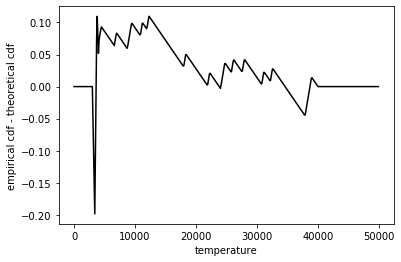

D_n: 0.19859317408063928


In [9]:
xlab = 'temperature'
ylab = 'empirical cdf - theoretical cdf'

y_values = np.array(y_empirical)-np.array(y_theoretical)
    
ax = plt.axes()
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
plt.plot(x, y_values, color='black')
plt.show()

D_n = np.max(np.abs(y_values))
print('D_n:', D_n)

The test itself is easy in `scipy.stats`:

In [10]:
result = stats.kstest(observed, al.cdf)
print(result)

KstestResult(statistic=0.2, pvalue=0.07048401841237437)


The resulting $p > \alpha$, so we accept the null hypothesis: the observed data appear to be compatible with Althea's theory.

### Other applications of the K-S test

#### Goodness of fit

The K-S test can be used as an alternative method for testing normality, or as a goodness-of-fit test for any other theoretical distribution. However, the standard test is only valid if the parameters (e.g. mean and variance) are *not* estimated from the data. 

If parameters *are* estimated from the data, we will need to use simulation to find an empirical distribution for $D_n$ under $H_0$.


#### Two sample test

The K-S test is often used to compare two samples (in the absence of a theoretical cdf) to test whether they follow the same distribution. 

In `scipy.stats`, this is done with the function `ks_2samp`.